In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

In [2]:
from cfollmer.objectives import log_g, relative_entropy_control_cost
from cfollmer.sampler_utils import FollmerSDE, SimpleForwardNetBN, SimpleForwardNet
from cfollmer.trainers import basic_batched_trainer

# The Model

\begin{align}
\theta &\sim \mathcal{N}(\theta | 0, \sigma_w^2 \mathbb{I}) \\
y_i | x_i, \theta &\sim  \mathcal{N}(y | f(x_i;\theta), \sigma_y^2 \mathbb{I})
\end{align}

We want samples from $p(\theta | \{(y_i, x_i)\})$. Note $f(x; \theta)$ is a neural net with params $\theta$

## Loading the StepFunc dataset

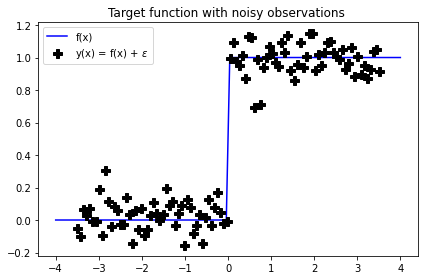

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"


# Test inputs
num_test_samples = 100
X_test = np.linspace(-4, 4, num_test_samples).reshape(num_test_samples,1)

# Noise free training inputs
X_train = np.linspace(-3.5, 3.5, 100).reshape(-1,1)
#f_train = np.cos(X_train) 
f_train = np.heaviside(X_train, 0)

# Noise-free training outputs
#f = np.cos(X_test)
f = np.heaviside(X_test, 0)
y_test  = f

# Noisy training Inputs with additive Gaussian noise (zero-mean, variance sigma_n)
sigma_n = 0.1

mu = np.zeros(X_train.size)
epsilon = np.random.multivariate_normal(mu, sigma_n**2 * np.eye(X_train.size))

# Noisy targets
y_train = f_train + epsilon.reshape(X_train.size,1)

# Noisy observations
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(X_test, f, 'b', label = 'f(x)')
ax.plot(X_train, y_train, 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"



X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}


In [5]:
import torch.nn.functional as F


class OnedRegressionForwardNet(object):
    
    def __init__(
        self, input_dim=1, output_dim=1, depth=None,
        width=20, width_seq=None, device="cpu", activation=F.relu
    ):
        
        self.device = device
        self.output_dim = output_dim
        self.input_dim = input_dim 
        self.activation = activation
        
        self.depth = depth
        if not self.depth:
            self.depth = 1
        if not width_seq:
            self.width = width
            self.width_seq = [self.width] * (self.depth + 1)
            self.shapes = [(self.width_seq[i-1], self.width_seq[i])  for i in range(1,self.depth)]
            self.shapes += [(self.width_seq[-1], self.output_dim)]
            self.shapes = [(self.input_dim, self.width_seq[0])] + self.shapes
        
        self.dim = sum([wx * wy + wy for wx, wy in self.shapes])
        
    def forward(self, x, Θ):
        index = 0
        n, d = x.shape
        
#         dim_bl =  sum([wx * wy + wy for wx, wy in self.shapes[:-1]])
#         Θ[:dim_bl] = (Θ[:dim_bl] - Θ[:dim_bl].mean()) / Θ[:dim_bl].std()
#         σ_Θ, μ_Θ = Θ.std(), Θ.mean()
#         Θ = (Θ - μ_Θ) / σ_Θ

        for wx, wy in self.shapes[:-1]:
            x = F.linear(
                x,
                Θ[index: index + wx * wy].reshape(wy, wx),
                Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy)
            )
            x = self.activation(x)
            index += wx * wy  + wy
        wx, wy = self.shapes[-1]
        x = F.linear(
            x,
            Θ[index: index + wx * wy].reshape(wy, wx), #* σ_Θ + μ_Θ,
            Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy) # * σ_Θ + μ_Θ
        )
        return x.to(self.device)
    
    def map_forward(self, x, Θ):
        preds_func = lambda θ: self.forward(x, θ)
        batched_preds = torch._vmap_internals.vmap(preds_func)
        preds = torch.hstack(list(map(preds_func, Θ)))
        return preds
        

In [47]:
net = OnedRegressionForwardNet(
    1,1, device=device, depth=3, width=85, activation=F.relu
)

def ln_prior(Θ, σ_w=1.6):
    """
    Logistic regresion bayesian prior
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w**2 


def log_likelihood_vmap(Θ, X, y, net=net, σ_y=0.1):
    """
    Hoping this implementation is less buggy / faster
    
    still feels a bit slow.
    """
    preds_func = lambda θ: net.forward(X, θ)
#     batched_preds = torch._vmap_internals.vmap(preds_func)
#     import pdb; pdb.set_trace()
    preds = torch.hstack(list(map(preds_func, Θ)))

    diff = preds - y
#     import pdb; pdb.set_trace()
    diff_sq_fld = -0.5 * (diff**2).sum(dim=0) / σ_y**2

    return diff_sq_fld

In [77]:
class SimpleForwardNetBN_larger(torch.nn.Module):

    def __init__(self, input_dim=1, width=20, activation=torch.nn.ReLU):
        super(SimpleForwardNetBN_larger, self).__init__()
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim + 1, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, input_dim )
        )
        
        self.nn[-1].weight.data.fill_(0.0)
        

    def forward(self, x):
        return self.nn(x)

# class SimpleForwardNetBN_larger(torch.nn.Module):

#     def __init__(self, input_dim=1, width=20, activation=torch.nn.ReLU):
#         super(SimpleForwardNetBN_larger, self).__init__()
        
#         self.nn = torch.nn.Sequential(
#             torch.nn.Linear(input_dim + 1, width) , activation(),
#             torch.nn.Linear(width, width), activation(),
#             torch.nn.Linear(width, width), activation(),
#             torch.nn.Linear(width, width), activation(),
#             torch.nn.Linear(width, input_dim )
#         )
        
#         self.nn[-1].weight.data.fill_(0.0)
        

#     def forward(self, x):
#         return self.nn(x)

In [78]:
γ = 0.1
Δt = 0.01

import gc
gc.collect()
torch.cuda.empty_cache()
# SimpleForwardNet
# γ = 1
# Δt = 0.05 - \sigma_w = 10-6
sde, losses = basic_batched_trainer(
    γ, Δt, ln_prior, log_likelihood_vmap, net.dim, X_train, y_train,
    method="euler", stl=True, adjoint=False, optimizer=None,
    num_steps=300, batch_size_data=20, batch_size_Θ=30,
    batchnorm=True, device=device, lr=0.007, drift = SimpleForwardNetBN_larger, net = None, schedule="linear",
    γ_min=0.001, γ_max=0.4
)

Widget Javascript not detected.  It may not be installed or enabled properly.


/local/scratch/home/fav25/ControlledFollmerDrift/cfollmer/objectives.py:136: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  f = _vmap_internals.vmap(f_)
/local/scratch/home/fav25/ControlledFollmerDrift/cfollmer/objectives.py:137: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  f_detached = _vmap_internals.vmap(sde.f_detached)


-6.283039093017578
3199.75439453125
34.38747787475586
-14.663962364196777
5.450963020324707
-1.157095193862915
-1.395750880241394
4.948510646820068
3.6347827911376953
23.647621154785156
5.860076904296875
3.6291770935058594
18.0366268157959
-5.830363750457764
5.637592315673828
-0.5858594179153442
3.7118167877197266
0.9043754935264587
-2.244798421859741
-0.47116681933403015
1.3511065244674683
-7.565911769866943
-10.572421073913574
-11.905118942260742
-5.343013286590576
-14.314908027648926
-12.356218338012695
-1.4655404090881348
-13.67151165008545
-10.580316543579102
-16.5789852142334
-11.040666580200195
-18.27924346923828
-14.543380737304688
-18.20269203186035
-14.580252647399902
-14.290648460388184
-17.17817497253418
-14.170625686645508
-21.48462677001953
-21.928020477294922
-19.80996322631836
-19.865306854248047
-15.428114891052246
-21.525001525878906
-20.202699661254883
-20.583192825317383
-22.060388565063477
-20.6189022064209
-24.8718318939209
-17.43008804321289
-23.75737762451172
-2

-32.24432373046875
-30.290456771850586
-30.97150993347168
-31.322378158569336
-32.044857025146484
-33.30519104003906
-29.839370727539062
-32.67212677001953
-32.829254150390625
-33.4056510925293
-32.32355880737305
-31.433725357055664
-31.91485023498535
-30.12740135192871
-32.09836959838867
-32.40336227416992
-31.784055709838867
-32.98186492919922
-31.879104614257812
-32.28776168823242
-32.76728057861328
-31.345046997070312
-31.118732452392578
-31.53061294555664
-31.452056884765625
-32.277008056640625
-30.727848052978516
-32.968955993652344
-32.868186950683594
-32.62974166870117
-31.6521053314209
-31.72626304626465
-32.99416732788086
-32.86916732788086
-32.65066146850586
-31.12831687927246
-31.58619499206543
-30.724637985229492
-31.158811569213867
-33.84231185913086
-33.28384017944336
-31.67220115661621
-33.28190231323242
-30.696027755737305
-32.12839889526367
-31.82330894470215
-33.346282958984375
-31.800888061523438
-32.926265716552734
-30.29829978942871
-32.20204544067383
-32.67098999

-33.0212287902832
-32.25352478027344
-33.8136100769043
-33.82299041748047
-32.90315246582031
-32.097469329833984
-32.78831100463867
-33.13936233520508
-32.76573944091797
-32.34077835083008
-32.07705307006836
-33.11791229248047
-32.933467864990234
-33.267669677734375
-32.72336959838867
-33.19419479370117
-33.652339935302734
-32.42471694946289
-31.19440269470215
-33.41558837890625
-33.18241500854492
-33.94440841674805
-32.328338623046875
-31.025297164916992
-33.08578872680664
-33.42961120605469
-32.77884292602539
-32.72980880737305
-32.2709846496582
-33.27267837524414
-31.529565811157227
-32.47333908081055
-34.24188995361328
-33.46934127807617
-34.25312805175781
-32.608192443847656
-32.8208122253418
-32.65742492675781
-33.30662536621094
-33.326351165771484
-32.99733352661133
-32.66804122924805
-34.0277099609375
-31.963693618774414
-33.383846282958984
-33.15428924560547
-31.568973541259766
-32.493797302246094
-32.66245651245117
-34.212562561035156
-32.3557243347168
-33.701663970947266
-32

-32.480770111083984
-31.98406410217285
-33.46049118041992
-32.2763557434082
-34.238338470458984
-32.92745590209961
-34.14534378051758
-33.388160705566406
-32.96377182006836
-32.457977294921875
-33.72970962524414
-33.382015228271484
-33.45754623413086
-33.39273452758789
-32.64763259887695
-33.24357604980469
-33.985958099365234
-32.11310958862305
-33.789306640625
-33.4840087890625
-31.83510398864746
-34.563148498535156
-32.631839752197266
-33.97993850708008
-33.59777069091797
-33.030391693115234
-31.7069034576416
-31.783987045288086
-33.145164489746094
-33.131771087646484
-33.21010971069336
-34.17820358276367
-33.414573669433594
-33.630008697509766
-33.01499938964844
-33.36100387573242
-31.84148597717285
-33.25931930541992
-32.79305648803711
-33.85831069946289
-31.456785202026367
-33.26390838623047
-32.64854049682617
-32.14200973510742
-34.60477828979492
-33.699344635009766
-32.319454193115234
-32.499141693115234
-33.9840202331543
-32.65822982788086
-32.04191207885742
-33.969120025634766

In [79]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [80]:
net.dim

14876

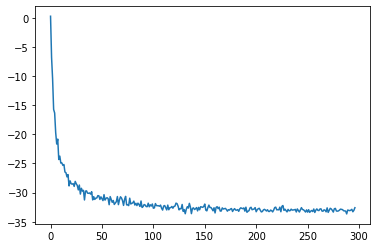

In [81]:
plt.plot(losses[3:])

In [82]:
gc.collect()
torch.cuda.empty_cache()

t_size = int(math.ceil(1.0/Δt))
ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 30
Θ_0 = torch.zeros((no_posterior_samples, net.dim)).to(device)

torch.cuda.empty_cache()
Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

(array([3., 1., 5., 5., 3., 2., 5., 3., 1., 2.]),
 array([-0.26395965, -0.22651778, -0.18907592, -0.15163404, -0.11419217,
        -0.07675031, -0.03930844, -0.00186657,  0.0355753 ,  0.07301717,
         0.11045904], dtype=float32),
 <BarContainer object of 10 artists>)

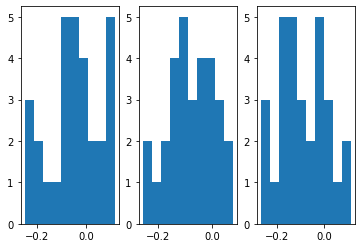

In [83]:
torch.cuda.empty_cache()
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].cpu().detach().numpy())
ax2.hist(Θ_1[:,1].cpu().detach().numpy())
ax3.hist(Θ_1[:,-23].cpu().detach().numpy())

In [84]:
# pred = net.map_forward(X_train, Θ_1.mean(dim=0).reshape(1,-1))#.mean(axis=1)
end = 15.5
X_train_2 = torch.linspace(-end, end, 100).reshape(-1,1).to(device)

pred_ = net.map_forward(X_train_2, Θ_1)
pred = pred_.mean(axis=1)

σ  = pred_.std(axis=1)

<ipython-input-5-d7f6014d9ca7>:55: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_preds = torch._vmap_internals.vmap(preds_func)


In [85]:
σ.shape, pred.shape

(torch.Size([100]), torch.Size([100]))

In [86]:
# import pickle

# pickle.dump( Θ_1, open( "Theta_1_best_2.pkl", "wb" ) )
# pickle.dump((sde, Δt, ts), open( "best_sd_2e.pkl", "wb" ))

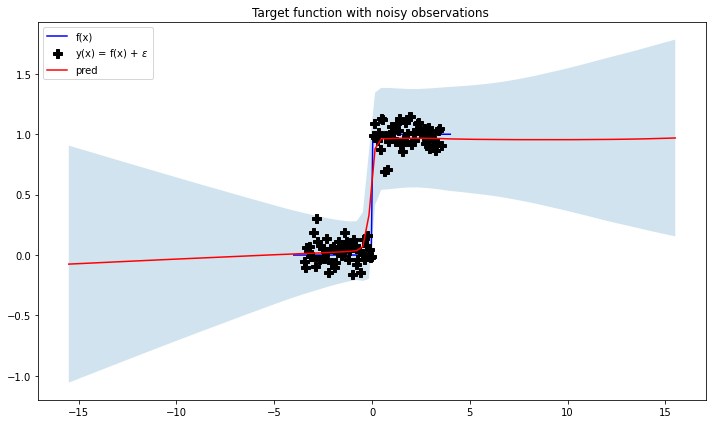

In [87]:
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
ax.plot(X_test.detach().cpu(), f, 'b', label = 'f(x)')
ax.plot(X_train.detach().cpu(), y_train.detach().cpu(), 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
ax.plot(X_train_2.detach().cpu(), pred.detach().cpu(), color="red", label="pred")

σ_p , σ_m = (pred-2*σ).detach().cpu().numpy(), (pred+2*σ).detach().cpu().numpy()
ax.fill_between(X_train_2.detach().cpu().flatten(), σ_p.flatten() , σ_m.flatten(), alpha=.2)
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

Text(0.5, 1.0, 'Sampled Posterior Weights')

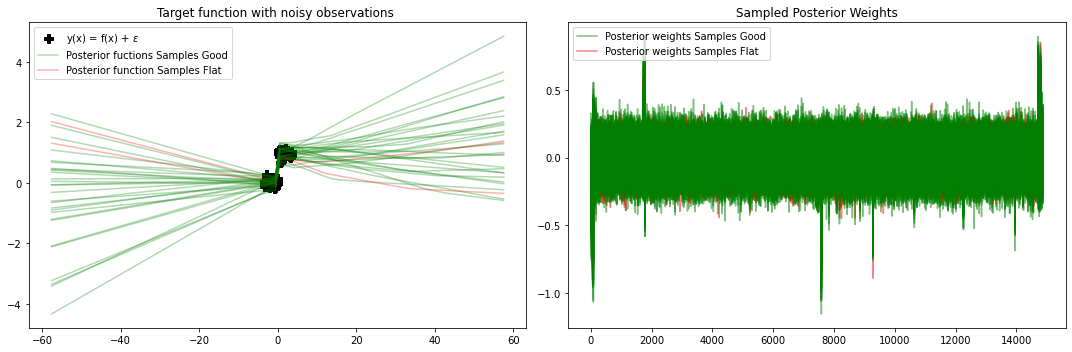

In [88]:

fig, (ax, ax1) = plt.subplots(1,2, figsize=(15, 5), tight_layout=True)
# ax.plot(X_test.detach().cpu(), f, 'b', label = 'f(x)')
ax.plot(X_train.detach().cpu(), y_train.detach().cpu(), 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
# ax.plot(X_train.detach().cpu(), pred.detach().cpu(), color="red", label="pred")


zero_ind = torch.abs(X_train).argmin()

thresh = 10
label_2, label_1 = True, True

end=57.6
X_train_2 = torch.linspace(-end, end, 100).reshape(-1,1).to(device)

for i in range(30):
#     print(Θ_1[i,:3])
    θ = Θ_1[i,:,]
    pred = net.forward(X_train_2, θ).mean(axis=1)
    pred_min, pred_max = pred[zero_ind-thresh], pred[zero_ind+thresh]
    label = True if i==0 else False
    if torch.abs(pred_min - pred_max) < 0.25:
        ax.plot(
            X_train_2.detach().cpu(), pred.detach().cpu(),
            alpha=0.3, color="red", label="Posterior function Samples Flat" if label_1 else None
        )
        ax1.plot(θ.detach().cpu(),  alpha=0.5, color="red", label="Posterior weights Samples Flat"  if label_1 else None)
        label_1 = False
    else:
        ax.plot(
            X_train_2.detach().cpu(), pred.detach().cpu(),
            alpha=0.3, color="green", label="Posterior fuctions Samples Good" if label_2 else None
        )
        ax1.plot(θ.detach().cpu(),  alpha=0.5, color="green", label="Posterior weights Samples Good" if label_2 else None )
        label_2 = False 
        
        
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

ax1.legend(loc = 'upper left')
ax1.set_title('Sampled Posterior Weights')
# plt.plot(X_train.detach().cpu(), y_train.detach().cpu())



# MAP Baseline - Answer is ok now, wildly overfits compared to bayesnet

In [54]:
net_map = OnedRegressionForwardNet(1,1, device=device, depth=1, width=10)

Θ_map = torch.normal(0,1, (1,net_map.dim), requires_grad=True, device=device) # torch.zeros((1, dim), requires_grad=True, device=device)
optimizer_map = torch.optim.Adam([Θ_map], lr=0.5)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)

losses_map = []
num_steps = 2000
for i in tqdm(range(num_steps)):
    optimizer_map.zero_grad()

    if isinstance(optimizer_map, torch.optim.LBFGS):
        def closure_map():
            loss_map = log_likelihood_vmap()
            optimizer_map.zero_grad()
            loss_map.backward()
            return loss

        optimizer_map.step(closure_map)
        losses_map.append(closure_map().item())
    else:
        loss_map = -(log_likelihood_vmap(Θ_map, X_train, y_train, net=net_map) + 0 * ln_prior(Θ_map))
        optimizer_map.zero_grad()
        loss_map.backward()
#         print(Θ_map.sum())

        optimizer_map.step()
#         print(loss_map.item())
        losses_map.append(loss_map.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

In [357]:
pred = net_map.map_forward(X_train, Θ_map)

C:\Users\vargf\AppData\Local\Temp/ipykernel_25680/2698751039.py:47: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_preds = torch._vmap_internals.vmap(preds_func)


In [358]:
Θ_map

tensor([[ 0.0689, -1.3282, -1.8303, -0.0302,  0.7726,  0.6816, -0.0398, -0.2844,
         -0.8827, -1.2118, -4.2557,  0.6610, -0.8504, -0.2750, -3.0124, -1.6717,
         -1.9313, -1.2023, -3.1821, -4.1283,  0.6745, -0.8429,  0.6224,  0.9746,
          0.9008, -0.2274,  0.5632,  0.6936, -0.2356, -0.0162,  1.0680]],
       device='cuda:0', requires_grad=True)

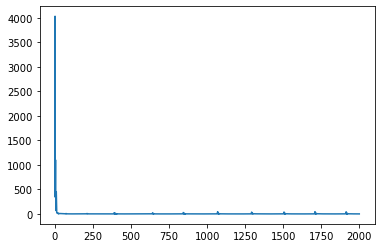

In [359]:
plt.plot(losses_map[:])

Text(0.5, 1.0, 'Target function with noisy observations ')

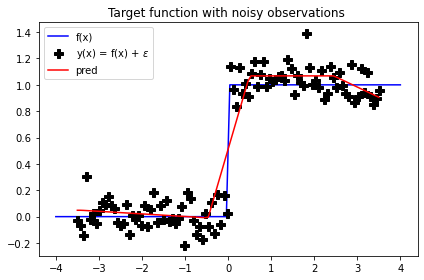

In [360]:
# plt.plot(X_train.detach().cpu(), pred.flatten().detach().cpu() )

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(X_test.detach().cpu(), f, 'b', label = 'f(x)')
ax.plot(X_train.detach().cpu(), y_train.detach().cpu(), 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
ax.plot(X_train.detach().cpu(), pred.detach().cpu(), color="red", label="pred")
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

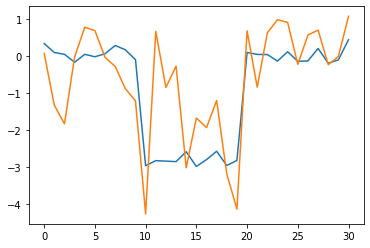

In [364]:
plt.plot(Θ_1.mean(dim=0).detach().cpu())
plt.plot(Θ_map.detach().cpu().flatten());

In [362]:
Θ_map.shape

torch.Size([1, 31])

In [354]:
Θ_1.shape

torch.Size([100, 31])

In [363]:
Θ_1.mean(dim=1).shape

torch.Size([100])